# Import necessary libraries

In [1]:
# !pip install datasets
# !pip install evaluate
# !pip install transformers
# !pip install accelerate -U
# !pip install transformers[torch]

In [2]:
import os, sys
import torch
import evaluate
import accelerate
import numpy as np
import transformers
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from shutil import copyfile
from google.colab import drive
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_metric
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from transformers import DistilBertTokenizer,TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments, InputExample, InputFeatures, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load the dataset

In [3]:
drive.mount('/content/drive')
copyfile('/content/drive/My Drive/Taxonomy_Classification_AI/labeled_incidents.csv', 'labeled_incidents.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'labeled_incidents.csv'

Open the labeled dataset of Incidents:

In [4]:
df = pd.read_csv("labeled_incidents.csv")
df = df.loc[:, ['labels', 'description']]

Check NA's:

In [5]:
missing_values = df.isnull().sum()
print("Missing values in each column: \n", missing_values)

Missing values in each column: 
 labels         0
description    0
dtype: int64


In the column "clean-review" we have the descriptions lemmatazied and pre-processed, the *__corpus__*. So, we only need to re-do those steps that come after the creation of the corpus, if necessary.

# Classification

Classification using __TFBertForSequenceClassification__ from hugging face

First, let's do the necessary changes to the dataframe to work with Hugging Face models:

In [6]:
value_count=df['labels'].value_counts()
print(value_count, "\n")

SOCIAL HARM             218
OPERATIONAL INCIDENT    145
SECURITY AND SAFETY     135
PRIVACY VIOLATION        58
Name: labels, dtype: int64 



In [7]:
# df['category'] = pd.Categorical(df.labels, ordered=True).codes
df['category'] = df['labels'].astype('category').cat.codes
df['category'].unique()

array([2, 3, 0, 1], dtype=int8)

In [8]:
value_count=df['category'].value_counts()
print(value_count, "\n")

3    218
0    145
2    135
1     58
Name: category, dtype: int64 



In [9]:
mapLabels = pd.DataFrame(df.groupby(['category', 'labels']).count())

# drop count column
mapLabels.drop(['description'], axis = 1, inplace = True)
label2Index = mapLabels.to_dict(orient='index')

print (f"label2Index :{label2Index}")
print (type(label2Index))
#print (f"index2Label :{index2Label}")

label2Index :{(0, 'OPERATIONAL INCIDENT'): {}, (1, 'PRIVACY VIOLATION'): {}, (2, 'SECURITY AND SAFETY'): {}, (3, 'SOCIAL HARM'): {}}
<class 'dict'>


In [10]:
index2label = {}

for key in label2Index:
  print (f"{key[1]} -> {key[0]}")
  index2label[key[1]] = key[0]

OPERATIONAL INCIDENT -> 0
PRIVACY VIOLATION -> 1
SECURITY AND SAFETY -> 2
SOCIAL HARM -> 3


In [11]:
label2Index = {v: k for k, v in index2label.items()}

print (f'label2Index: {label2Index}')
print (f'index2label: {index2label}')

label2Index: {0: 'OPERATIONAL INCIDENT', 1: 'PRIVACY VIOLATION', 2: 'SECURITY AND SAFETY', 3: 'SOCIAL HARM'}
index2label: {'OPERATIONAL INCIDENT': 0, 'PRIVACY VIOLATION': 1, 'SECURITY AND SAFETY': 2, 'SOCIAL HARM': 3}


In [12]:
df.head()

,labels,description,category
0,SECURITY AND SAFETY,A self-driving public shuttle by Keolis North ...,2
1,SECURITY AND SAFETY,An Uber autonomous vehicle (AV) in autonomous ...,2
2,SOCIAL HARM,YouTube’s content filtering and recommendation...,3
3,SOCIAL HARM,Google Image returns results that under-repres...,3
4,SOCIAL HARM,Researchers from Boston University and Microso...,3


<Axes: ylabel='labels'>

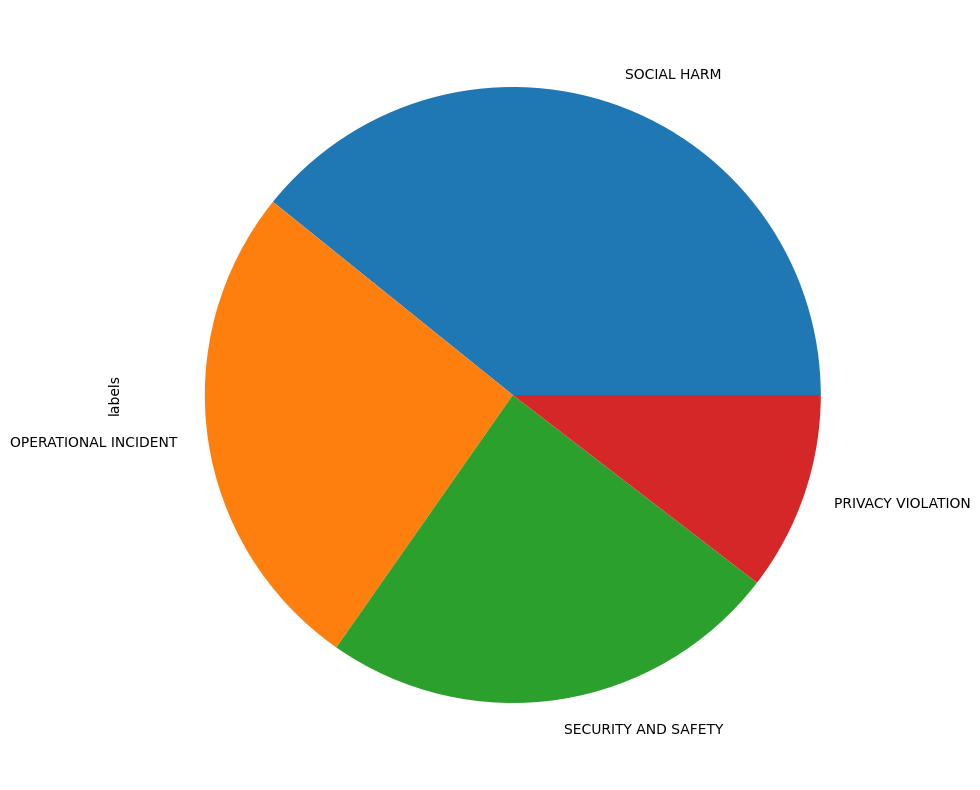

In [13]:
df.labels.value_counts().plot(kind='pie', figsize=(10,10))

Divide in train, test and validation:

In [14]:
data_texts = df["description"].to_list() # Features (not-tokenized yet)
data_labels = df["category"].to_list() # Labels

In [15]:
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(data_labels)

In [16]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, labels_encoded, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
#train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

Tokenize:

In [17]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Pass the data to tensor flow:

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

Training:

In [27]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [28]:
model.fit(train_dataset.shuffle(1000).batch(8), epochs=5, batch_size=8,
          validation_data=val_dataset.shuffle(1000).batch(8))

Epoch 1/5
56/56 [==============================] - 32s 194ms/step - loss: 9.2400 - accuracy: 0.3761 - val_loss: 11.0812 - val_accuracy: 0.4107
Epoch 2/5
56/56 [==============================] - 6s 109ms/step - loss: 10.3824 - accuracy: 0.3874 - val_loss: 11.0812 - val_accuracy: 0.4107
Epoch 3/5
56/56 [==============================] - 6s 104ms/step - loss: 10.3824 - accuracy: 0.3874 - val_loss: 11.0812 - val_accuracy: 0.4107
Epoch 4/5
56/56 [==============================] - 5s 94ms/step - loss: 10.3824 - accuracy: 0.3874 - val_loss: 11.0812 - val_accuracy: 0.4107
Epoch 5/5
56/56 [==============================] - 6s 102ms/step - loss: 10.3824 - accuracy: 0.3874 - val_loss: 11.0812 - val_accuracy: 0.4107


Save the model:

In [21]:
save_directory = "/saved_models" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/saved_models/tokenizer_config.json',
 '/saved_models/special_tokens_map.json',
 '/saved_models/vocab.txt',
 '/saved_models/added_tokens.json')

Test new descriptions:

In [22]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# test_text = test_texts[4]
# test_text

In [24]:
# predict_input = loaded_tokenizer.encode(test_text,
#                                  truncation=True,
#                                  padding=True,
#                                  return_tensors="tf")

# output = loaded_model(predict_input)[0]
# print(output)
# prediction_value = tf.argmax(output, axis=1).numpy()[0]

# print(f"Predicted Value: {prediction_value}")
# print(f"Real value: {label_binarizer.inverse_transform(test_labels)[2]}")